# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [3]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.606379640107222
 0.484698866550308
 0.3922759781791081
 0.7450457529090424
 0.5144845015404576
 0.29332973122792627
 0.4587491906345028
 0.1482800720306915
 0.6465201369279091
 0.06138124692053304
 0.6445079369364795
 0.5400071393152944
 0.7567904000085415
 ⋮
 0.9476614236670423
 0.2510283977806267
 0.4943419133627476
 0.49283400697370205
 0.8764599937221115
 0.14497273281265077
 0.05993865726811931
 0.7233953653348673
 0.807112804894101
 0.48021160468689394
 0.6019130540008734
 0.3849815924157446

In [4]:
sum(a)

4.999754035264868e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [6]:
@time sum(a)

  0.004998 seconds (1 allocation: 16 bytes)


4.999754035264868e6

In [7]:
@time sum(a)

  0.004459 seconds (1 allocation: 16 bytes)


4.999754035264868e6

In [8]:
@time sum(a)

  0.004552 seconds (1 allocation: 16 bytes)


4.999754035264868e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [9]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/github-personal/Introduction-to-Julia/Project.toml`
  No Changes to `~/github-personal/Introduction-to-Julia/Manifest.toml`


In [12]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [19]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [30]:
c_sum(a)

4.999754035265293e6

In [31]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [32]:
c_sum(a) - sum(a)  

4.246830940246582e-7

In [33]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [34]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [38]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 406 samples with 1 evaluation.
 Range (min … max):  11.762 ms …  14.249 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.274 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.314 ms ± 385.221 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▂▂     ▁▄▂▄█▂                                            
  ▆▆▆▅████▇▆▆███████▆▄▅▃▄▃▅▄▆▅▄▃▆▅▃▁▂▂▃▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▂ ▄
  11.8 ms         Histogram: frequency by time         13.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.761558 msec


In [52]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 11.7616

In [53]:
using Plots
gr()

Plots.GRBackend()

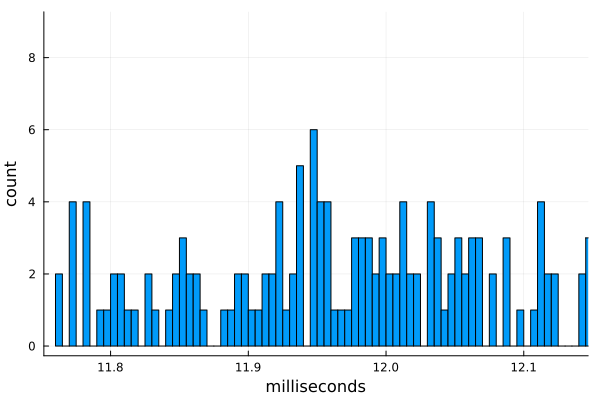

In [49]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [54]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [55]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1043 samples with 1 evaluation.
 Range (min … max):  4.392 ms …   7.165 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.630 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.780 ms ± 370.301 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄█▇▃▅▂                                                      
  ▅███████▅▅▄▄▅▆▄▅▇▇▆▇▅▇▅▄▄▄▃▄▃▃▃▄▂▃▃▃▃▃▂▃▃▃▂▃▂▃▃▃▂▂▁▂▂▁▂▁▂▂▂ ▃
  4.39 ms         Histogram: frequency by time        6.04 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [56]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.391986

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [60]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/github-personal/Introduction-to-Julia/Project.toml`
  No Changes to `~/github-personal/Introduction-to-Julia/Manifest.toml`


In [61]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [62]:
pysum(a)

4.999754035265293e6

In [63]:
pysum(a) ≈ sum(a)

true

In [64]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  700.439 ms … 715.469 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     702.104 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   705.163 ms ±   6.090 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  ▁ █ ▁     ▁                                          ▁   ▁  
  █▁▁█▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  700 ms           Histogram: frequency by time          715 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [65]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 11.7616
  "Python built-in" => 700.439
  "C -ffast-math"   => 4.39199

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [66]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/github-personal/Introduction-to-Julia/Project.toml`
  No Changes to `~/github-personal/Introduction-to-Julia/Manifest.toml`


In [67]:
Conda.add("numpy")

[ Info: Running `conda install -y numpy` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/brobert/.julia/conda/3/x86_64

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.5.2               |  py310h2ec42d9_0        1009 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        1009 KB

The following packages will be UPDATED:

  conda                              23.5.0-py310h2ec42d9_1 --> 23.5.2-py310h2ec42d9_0 



                                                                               
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [68]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1112 samples with 1 evaluation.
 Range (min … max):  3.950 ms …   7.569 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.366 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.485 ms ± 446.676 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄▃█▄▁                                                       
  ▇██████▇▆▅▅▅█▆▅▅▆▃▅▄▄▃▄▃▅▅▄▆▆▅▆▆▃▅▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁ ▃
  3.95 ms         Histogram: frequency by time        5.78 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [69]:
numpy_sum(a)

4.999754035264871e6

In [70]:
numpy_sum(a) ≈ sum(a)

true

In [71]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 11.7616
  "Python numpy"    => 3.95018
  "Python built-in" => 700.439
  "C -ffast-math"   => 4.39199

# 5. Python, hand-written 

In [72]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x18a229d80>

In [74]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  849.254 ms … 907.689 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     854.825 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   862.293 ms ±  22.426 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▁  ▁  █                                                    ▁  
  ██▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  849 ms           Histogram: frequency by time          908 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [75]:
sum_py(a)

4.999754035265293e6

In [76]:
sum_py(a) ≈ sum(a)

true

In [77]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 11.7616
  "Python numpy"        => 3.95018
  "Python hand-written" => 849.254
  "Python built-in"     => 700.439
  "C -ffast-math"       => 4.39199

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [78]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:994

In [79]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 994 samples with 1 evaluation.
 Range (min … max):  4.319 ms …   7.035 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.968 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.013 ms ± 295.213 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                      ▁▅▇▅█▃▃▁▄▁        ▁                      
  ▂▂▃▃▄▃▃▂▂▂▃▂▃▂▂▂▄▄▅███████████▇▇▃▄▅▅▅▆█▇▆▆▇▄▄▄▃▃▃▂▂▃▁▃▂▂▁▁▁ ▃
  4.32 ms         Histogram: frequency by time        5.74 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [80]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 11.7616
  "Python numpy"        => 3.95018
  "Python hand-written" => 849.254
  "Python built-in"     => 700.439
  "Julia built-in"      => 4.31948
  "C -ffast-math"       => 4.39199

# 7. Julia (hand-written) 

In [81]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [82]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 396 samples with 1 evaluation.
 Range (min … max):  12.139 ms …  14.543 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.627 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.638 ms ± 306.080 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃  ▂▄▂▆   ▆  ▄▄▃█ ▄▂▄▄▇▂▄▄▄▁▂                               
  ▅▆██▆████▇█▆█▆▇████▇███████████▄▆▅▁▁▄▃▃▃▃▁▁▃▃▃▃▁▃▁▁▁▁▁▁▃▁▁▁▃ ▄
  12.1 ms         Histogram: frequency by time         13.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [83]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 11.7616
  "Python numpy"        => 3.95018
  "Julia hand-written"  => 12.1394
  "Python hand-written" => 849.254
  "Python built-in"     => 700.439
  "Julia built-in"      => 4.31948
  "C -ffast-math"       => 4.39199

# 8. Julia (hand-written w. simd) 

In [84]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [85]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 956 samples with 1 evaluation.
 Range (min … max):  4.461 ms …   6.894 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.152 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.213 ms ± 206.971 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                          ▂▂▄▅▅▄▆█▁▁        ▁                  
  ▂▂▁▁▁▁▂▁▁▁▂▁▁▂▂▁▂▃▁▃▂▃▄▇██████████▅▆▇▆▆▇▅▇██▇▇▇▅▅▃▄▃▄▃▃▃▃▃▃ ▄
  4.46 ms         Histogram: frequency by time        5.74 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [86]:
mysum_simd(a)

4.999754035264923e6

In [87]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.46098
  "C"                       => 11.7616
  "Python numpy"            => 3.95018
  "Julia hand-written"      => 12.1394
  "Python hand-written"     => 849.254
  "Python built-in"         => 700.439
  "Julia built-in"          => 4.31948
  "C -ffast-math"           => 4.39199

# Summary

In [88]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................4.0
Julia built-in..............4.3
C -ffast-math...............4.4
Julia hand-written simd.....4.5
C..........................11.8
Julia hand-written.........12.1
Python built-in...........700.4
Python hand-written.......849.3
